In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm
import wandb

/usr0/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
pd.options.display.max_rows = 150

In [3]:
api = wandb.Api(timeout=20)

In [15]:
filters = {
    "state": "finished"
}

# runs = api.runs("flow-graphs-cmu/flow_graphs-code", filters=filters)

sweeps = [
    "zt62jnek", # RISEC multiseed, all. fewshot 1-10
    "2fvdobq5", #  RISEC single seed, fewshot 1-10
    "v57twc84", # RISEC AMR only, multiseed, fewshot 1-10
    "cb3sa5r1", # Chemu multiseed, AMR only. fewshot 1-50. 
    "d7163mab" # Chemu multiseed, all. fewshot 1-50
]


runs = []
for sweep_id in sweeps:
    sweep = api.sweep(f"flow-graphs-cmu/flow_graphs-code/{sweep_id}")
    runs.extend([run for run  in sweep.runs if "incorrect_amr" not in run.tags])

In [16]:
df_dicts = []

for run in tqdm(runs):
    try:
        test_f1  = run.history(keys=["test_f1"], pandas=False)[0]["test_f1"]
        dep = run.history(keys=["dep"], pandas=False)[0]["dep"]
        amr = run.history(keys=["amr"], pandas=False)[0]["amr"]
        df_dicts.append({**run.config, "test_f1": test_f1, "amr": amr, "dep": dep})
    except:
        continue

results_df = pd.DataFrame(df_dicts)

  0%|          | 0/281 [00:00<?, ?it/s]

In [17]:
dataset_name_mapping = {
    "risec": "RISeC",
    "japflow": "Cooking Flow Graphs",
    "chemu": "Chemical Patents",
    "mscorpus": "Materials Science",
}

In [18]:
results_df["case"] = ""
results_df["case"][results_df["dep"] == '0'] = "baseline"
results_df["case"][results_df["dep"] == '1'] = "dep"
results_df["case"][results_df["amr"] == '1'] = "amr"
results_df

/usr0/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr0/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr0/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,amr,dep,seed,fewshot,src_dataset,tgt_dataset,test_f1,case
0,0,1,2,0.10,risec,mscorpus,0.658874,dep
1,0,1,2,0.10,risec,chemu,0.923784,dep
2,0,1,2,0.10,risec,japflow,0.528753,dep
3,0,1,1,0.10,risec,mscorpus,0.664195,dep
4,0,1,1,0.10,risec,chemu,0.929849,dep
...,...,...,...,...,...,...,...,...
188,0,0,1,0.01,chemu,risec,0.120398,baseline
189,0,0,1,0.01,chemu,japflow,0.087038,baseline
190,0,0,0,0.01,chemu,mscorpus,0.249895,baseline
191,0,0,0,0.01,chemu,risec,0.109771,baseline


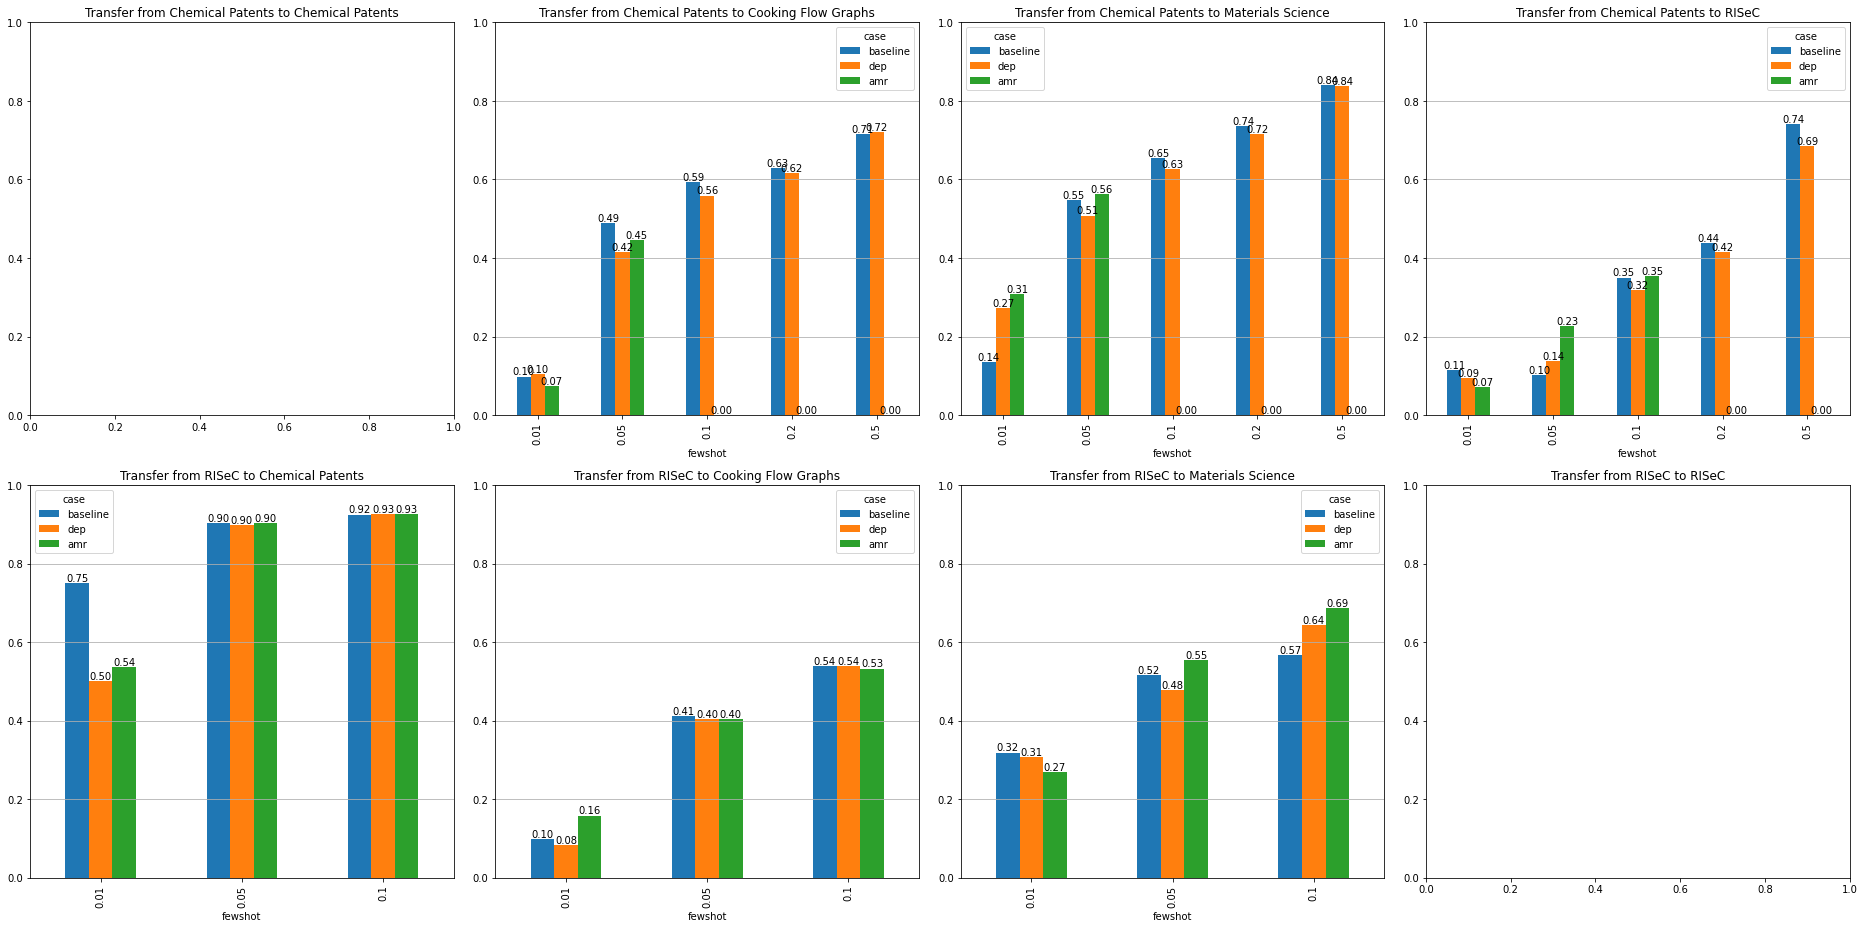

In [26]:
src_datasets = set(results_df["src_dataset"])
tgt_datasets = set(results_df["tgt_dataset"])

fig, axes = plt.subplots(len(src_datasets),len(tgt_datasets), figsize=(26, 13), tight_layout=True)
ax_iter = iter(axes.reshape([-1]))

for src_dataset in sorted(src_datasets):
    for tgt_dataset in sorted(tgt_datasets):
        ax = next(ax_iter)
        ax.set_title(f"Transfer from {dataset_name_mapping[src_dataset]} to {dataset_name_mapping[tgt_dataset]}")
        ax.set_ylim(0, 1)
        if src_dataset == tgt_dataset:
            continue
        results_viz = results_df[(results_df["src_dataset"] == src_dataset) & (results_df["tgt_dataset"] == tgt_dataset)].groupby(["fewshot", "case"])["test_f1"].aggregate(["mean"]).unstack(1)       
        results_viz.columns = results_viz.columns.droplevel()
        graph = results_viz[["baseline", "dep", "amr"]].plot.bar(ax=ax)
        graph.grid(axis="y", which="both")
        for bars in ax.containers:
            ax.bar_label(bars, fmt="%2.2f")
